# Mapping human lymph node cell types to 10X Visium with Cell2location

This contributed tutorial shows how to use cell2location method for spatially resolving fine-grained cell types by integrating 10X Visium data with scRNA-seq reference of cell types. Cell2location is a principled Bayesian model that estimates which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, while modelling technical effects (platform/technology effect, contaminating RNA, unexplained variance).

<div class="alert alert-info">
Important

Cell2location is accessible via its own package, but is powered by scvi-tools. Please visit https://cell2location.readthedocs.io/en/latest/.

</div>

In this tutorial, we analyse a publicly available Visium dataset of the human lymph node from 10X Genomics, and spatially map a comprehensive atlas of 34 reference cell types derived by integration of scRNA-seq datasets from human secondary lymphoid organs.

- Cell2location provides high sensitivity and resolution by borrowing statistical strength across locations. This is achieved by modelling similarity of location patterns between cell types using a hierarchical factorisation of cell abundance into tissue zones as a prior (see paper methods).

- Using our statistical method based on Negative Binomial regression to robustly combine scRNA-seq reference data across technologies and batches results in improved spatial mapping accuracy. Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f$, can be estimated from sc/snRNA-seq data using either 1) NB regression or 2) a hard-coded computation of per-cluster average mRNA counts for individual genes.  We generally recommend using NB regression. This notebook shows use a dataset composed on multiple batches and technologies.When the batch effects are small, a faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.

- Cell2location needs untransformed unnormalised spatial mRNA counts as input. 

- You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see [paper methods for more guidance](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf)).


## Workflow diagram

![Figure 1.](https://raw.githubusercontent.com/BayraktarLab/cell2location/master/docs/images/FigS1_cell2location_workflow.png)  

## Loading packages <a class="anchor" id="Loading_packages"></a>

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [ ]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

import cell2location
import scvi

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

First, let's define where we save the results of our analysis:

In [ ]:
results_folder = './results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium and scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [ ]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<div class="alert alert-info">
Note
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.
</div>

You can still plot gene expression by name using standard scanpy functions as follows: 
```python
sc.pl.spatial(color='PTPRC', gene_symbols='SYMBOL', ...)
```

In [ ]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

<div class="alert alert-info">
Note
    
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [ ]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

In [ ]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad', 
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

  0%|          | 0.00/527M [00:00<?, ?B/s]

<div class="alert alert-warning">
Warning
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.
</div>

In [ ]:
adata_ref.var['SYMBOL'] = adata_ref.var.index 
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

<div class="alert alert-info">
Note
    
Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.
</div>

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

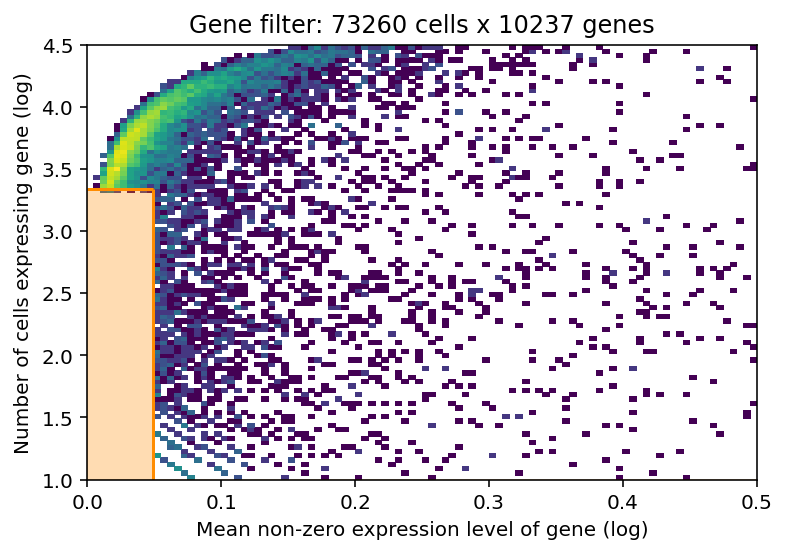

In [ ]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative Binomial regression model.


<div class="alert alert-block alert-message">
<b>Preparing anndata.</b>
First, prepare anndata object for the regression model:
</div>

<div class="alert alert-block alert-message">
<b>Training model.</b>
Then we train the model to estimate reference cell type signatures:
</div>

In [ ]:
# create and train the regression model
from cell2location.models import RegressionModel
# prepare anndata for the regression model
RegressionModel.setup_anndata(
    adata=adata_ref, 
    # 10X reaction / sample / batch
    batch_key='Sample', 
    # cell type, covariate used for constructing signatures
    labels_key='Subset', 
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=['Method']
)
mod = RegressionModel(adata_ref) 
mod.view_anndata_setup()

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(
    max_epochs=250, 
    batch_size=2500, 
    train_size=1, 
    lr=0.002, 
)

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 10237 │
│         n_cells          │ 73260 │
│         n_batch          │  23   │
│         n_labels         │  34   │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 250/250: 100%|██████████| 250/250 [19:59<00:00,  4.80s/it, v_num=1, elbo_train=2.88e+8]


<div class="alert alert-block alert-message">
<b>Determine if the model needs more training.</b>
</div>

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot.
This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase `max_epochs`.

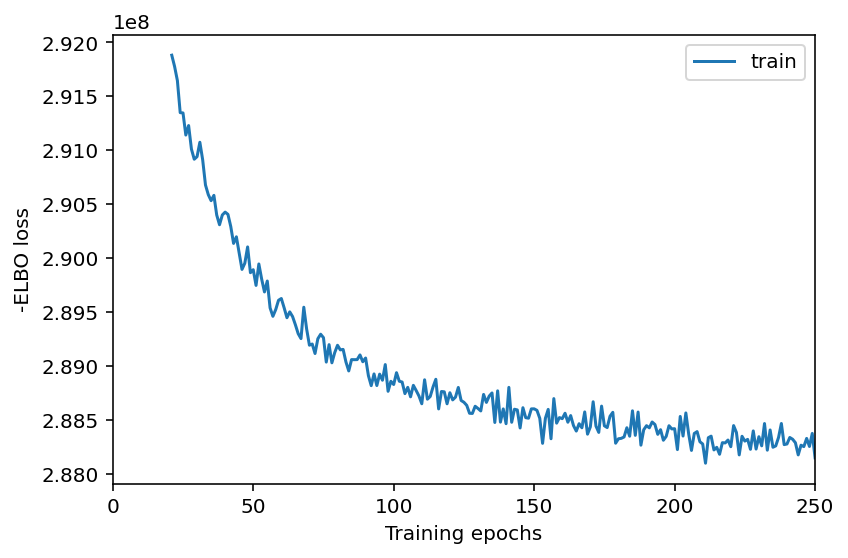

In [ ]:
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance
# (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, 
    sample_kwargs={
        'num_samples': 1000, 
        'batch_size': 2500, 
        'use_gpu': True
    },
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 56.01it/s]


'./results/lymph_nodes_analysis//reference_signatures/sc.h5ad'

<div class="alert alert-block alert-message">
<b>Examine QC plots.</b>
</div>

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

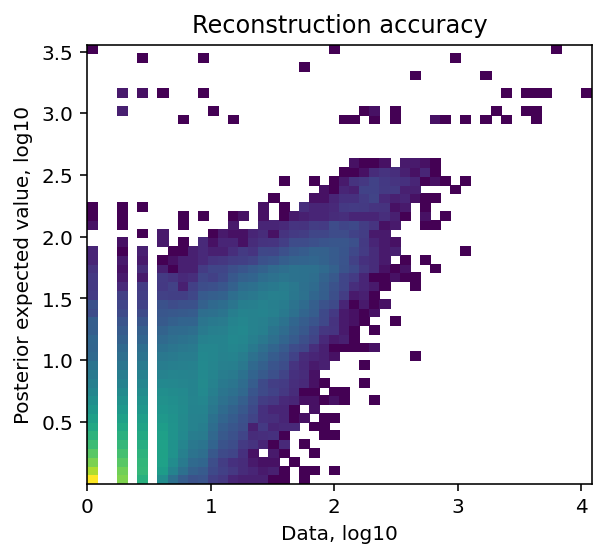

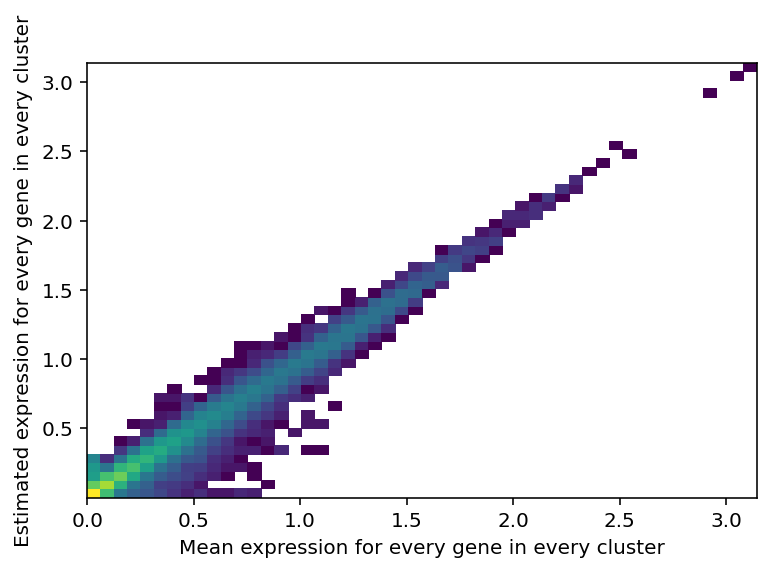

In [ ]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:
```python
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
```

<div class="alert alert-block alert-message">
<b>Extracting reference cell types signatures as a pd.DataFrame.</b>
All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:
</div>

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
GeneID-2,,,,,
ENSG00000188976,0.422873,0.238854,0.304739,0.340573,0.148950
ENSG00000188290,0.002055,0.000721,0.000750,0.055309,0.040174
ENSG00000187608,0.384433,0.212866,0.274928,0.512807,3.943279
ENSG00000186891,0.019475,0.000767,0.054012,0.067262,0.010874
ENSG00000186827,0.007602,0.000532,0.006271,0.029203,0.011210


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

<div class="alert alert-block alert-message">
<b>Find shared genes and prepare anndata.</b>
Subset both anndata and reference signatures:
</div>

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

<div class="alert alert-info">
Important
    
To use cell2location spatial mapping model, you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).
</div>

**Choosing hyperparameter `N_cells_per_location`!**
It is useful to adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.

**Choosing hyperparameter `detection_alpha`!**
You can often use the default value of `detection_alpha` hyperparameter (`detection_alpha=200`), but for datasets where you observe **within-batch variation in total RNA count that cannot be explained by tissue containing more cells** (histological examination) use `detection_alpha=20`.

In [ ]:
# create and train the model
# prepare anndata for cell2location model
from cell2location.models import Cell2location
Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

mod = Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
) 
mod.view_anndata_setup()

mod.train(
    max_epochs=30000, 
    # train using full data (batch_size=None)
    batch_size=None, 
    # use all data points in training because 
    # we need to estimate cell abundance at all locations
    train_size=1,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 10217 │
│         n_cells          │ 4035  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 28502/30000:  95%|█████████▌| 28501/30000 [1:06:03<03:27,  7.23it/s, v_num=1, elbo_train=4.54e+7]

<div class="alert alert-block alert-message">
<b>Exporting estimated posterior distributions of cell abundance and saving results:</b>
</div>

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

The model and output h5ad can be loaded later like this:
```python
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
```

<div class="alert alert-block alert-message">
<b>Assessing mapping quality.</b>
Examine reconstruction accuracy to assess if there are any issues with mapping.
The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated
</div>

In [ ]:
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. You expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). You expect total cell abundance to mirror high cellular density in the histology.

```python
fig = mod.plot_spatial_QC_across_batches()
```

## Visualising cell abundance in spatial coordinates <a class="anchor" id="Visualising"></a>

<div class="alert alert-info">
Note
    
We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present').
</div>


In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    colors = ['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC', 'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo']
    sc.pl.spatial(
        slide, 
        cmap='magma',
        # show first 8 cell types
        color=colors, 
        ncols=2, 
        size=1.3, 
        img_key='hires',
        # limit color scale at 99.2% quantile of cell abundance
        vmin=0, 
        vmax='p99.2' 
    )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters 
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide, 
        # labels to show on a plot
        color=clust_col, labels=clust_labels, 
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast', 
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6, 
        colorbar_position='right'
    )